In [3]:

import sympy as sp
import numpy as np

import matplotlib.pyplot as plt

## Markdown

In [4]:
x = sp.Symbol('x')
## Lab exercise: make a plot over the interval [-2pi, 2pi] of
## the root initial guess x0 vs. the root Newt finds. 

## We have made a slight modification for the purpose of ease
## of reading the response.  The roots "found" by Newton's
## method are all over the place, so we take the arctangent
## of them to adjust the scale to something reasonable.

## required lab will be data analysis + bonus Newt exercise in C plane.
## walk over interval [-2pi, 2pi], apply Newt n times, check which 
## root we are closest to, assign height.

## f = sympy function of x
## x = variable name
## n == number of iterations until we look for root.
## k == grid density
## a == left endpt
## b == right endpt
def rootPlot(f, x, n, k, a, b):
    dom = np.linspace(a, b, k)
    N = x - f/f.diff(x)
    IT = sp.lambdify(x, N)
    F = sp.lambdify(x, f)
    DEN = sp.lambdify(x, f.diff(x))
    
    plt.close() ## close previous plot
    fig, ax = plt.subplots()
    
    dom = np.linspace(a, b, k)
    plt.plot(dom, [F(xi) for xi in dom], \
             color="green", label="func")
    plt.plot([a, b], [0.0, 0.0], color="black")
    
    yv = []
    for x0 in dom:
        xi = x0
        ## TODO: check for divide by zero error
        for i in range(n):
            if np.abs(DEN(xi))<0.0001:
                xi = 0.0
                break
            xi = IT(xi)
        yv.append(np.arctan(xi))
    yv = np.array(yv)
    #yv=np.array(yv)
    plt.plot(dom, yv, 'ro', markersize=1.0, markeredgewidth=0.0, \
             color="red")
    
    plt.xticks([a, a + (b-a)/4, a+2*(b-a)/4, a+3*(b-a)/4, b])
    plt.show()

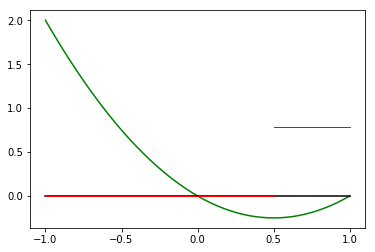

In [5]:

rootPlot(x*(x-1), x, 20, 1500, -1.0, 1.0)

## basinplot

In [7]:

## let's just create basinplot from the start.
## arguments described below.

## prog is a flag to indicate progress (for slow computations)
## if you don't have the tqdm library, erase this include and
## remove "tqdm.tqdm(range(xres)) if prog else" from the i 
## for loop below.
import tqdm

z = sp.Symbol('z')

def basinplot(f, z, roots, rootcol, RMIN, RMAX, IMIN, IMAX,\
              xres, yres, prog=False):
    ## get iterable Newton method
    N = z - f/f.diff(z)
    DF = sp.lambdify(z, f.diff(z), "mpmath")
    IT = sp.lambdify(z, N, "mpmath")
    ## setup image array
    IM = np.ndarray(shape=(yres, xres, 3), dtype=float)
    ## iterate over image pixels
    for i in tqdm.tqdm(range(xres)) if prog else range(xres):
        for j in range(yres):
            z0 = (i/xres)*(RMAX-RMIN)+RMIN + ((j/yres)*(IMAX-IMIN)+IMIN)*1j
            z1 = z0
            DEV = 1.0 ## keep track of distance from root.
            while DEV > 0.1:
                if abs(DF(z0))<0.0001:
                    DEV = 0.0
                else:
                    z1 = IT(z0)
                    DEV = abs(z1-z0)
                    z0 = z1
            rootFound = False
            for k in range(len(roots)):
                if abs(roots[k]-z0)<0.2:
                    rootFound = True
                    IM[j,i] = rootcol[k]
            if rootFound == False:
                IM[j,i] = np.array([0.0, 0.0, 0.0])
    plt.close()
    plt.figure(figsize=(12,12))
    plt.imshow(IM, extent=[RMIN, RMAX, IMIN, IMAX])
    plt.show()

⎡                    ________                   ________                   ___
⎢     1   √5        ╱ √5   5     1   √5        ╱ √5   5     √5   1        ╱   
⎢1, - ─ + ── - ⅈ⋅  ╱  ── + ─ , - ─ + ── + ⅈ⋅  ╱  ── + ─ , - ── - ─ - ⅈ⋅  ╱  - 
⎣     4   4      ╲╱   8    8     4   4      ╲╱   8    8     4    4     ╲╱     

_______                   __________⎤
√5   5     √5   1        ╱   √5   5 ⎥
── + ─ , - ── - ─ + ⅈ⋅  ╱  - ── + ─ ⎥
8    8     4    4     ╲╱     8    8 ⎦


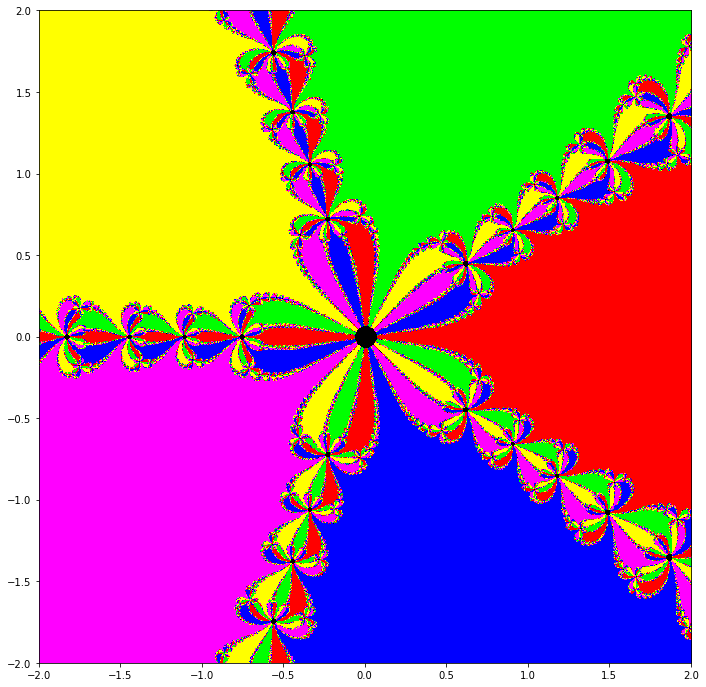

In [9]:

roots = sp.solve(z**5-1)
sp.pprint(roots)

basinplot(z**5-1, z, [complex(r) for r in roots],\
          np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 1.0, 0.0], [1.0,0.0,1.0]]), \
         -2.0, 2.0, -2.0, 2.0, 800, 800)

## Convert w.sask annd w.vic to master list
change file path and or file names



In [10]:
## Let's start by loading all the weather data, storing it in a list of dictionaries. An element of 
## this list will consist of the weather file headers, turned into a dict-object.  

## There will also be an additional weather-table key that will contain a list of dict objects. 
## containing the data the from a line of the file. 

import datetime as dt
import os as os
import fnmatch as fn
from operator import itemgetter

wsubdir = fn.filter(os.listdir('../data'), "w.*")
print("Weather subdirectories:", wsubdir)

## each file is of the form "key", "data" for several lines, then a blank space
## "Legend" then several (ignorable) lines, then a blank space
## "keys" separated by commas then
## remaining lines are the key values for each measurement. 

masterList = [] ## list of weather station dict objects

for wd in wsubdir:
    files = fn.filter(os.listdir('../data/'+wd), "eng-daily*.csv")
    for wdf in files:
        with open('../data/'+wd+'/'+wdf) as f:
            blanks=0
            content = f.readlines()
            FD = dict() ## file dict head.
            FL = [] ## file list.
            keys = []
            for LN in content:
                PL = LN.replace(u'\ufeff','').split(",")
                for i in range(len(PL)): # this removes the quotes around the numbers.
                    PL[i] = PL[i].translate({ord(c): None for c in '"\n'})
                if len(PL)==1 and PL[0]=='':
                    blanks+=1
                    if blanks==2 and PL[0]=='':
                        continue
                ## if blanks==0 we need to build the main dict
                ## if blanks==1 we ignore
                ## if blanks==2 we build the data.
                if blanks==0:
                    FD[PL[0]] = PL[1]
                    if PL[0]=="Station Name":
                        FD["Data"] = []
                if blanks==2:
                    if PL[0]=="Date/Time":
                        keys = PL
                    else:
                        FD["Data"].append( { keys[i] : PL[i] for i in range(len(keys)) } )
            masterList.append(FD)        

## make set of "Station Name"s. 
## use it to merge common station names into one (more useful) masterList.
sNames = { x['Station Name'] for x in masterList}
print("Station names:", sNames)

## return index of list of dict if dict keyed-element exists, -1 otherwise
def indIfExists(LOD, keyname, value):
    for i in range(len(LOD)):
        if LOD[i][keyname] == value:
            return i
    return -1

## run through masterlist, if that airport exists in mList we merge, if not, we copy it over.
mList = []
while len(masterList)>0:
    I = indIfExists(mList, 'Station Name', masterList[-1]['Station Name'])
    if I<0:
        mList.append(masterList.pop())
    else:
        mList[I]["Data"].extend(masterList.pop()["Data"])

## run through the weather station data, replace the date record with a datetime object
for WS in mList:
    badItems = set()
    for i in range(len(WS["Data"])):
        ## Let's convert the dict from strings to appropriate datetime and float objects
        ## dates with bad data we will flag and remove.
        for key, value in WS["Data"][i].items():
            if key=="Date/Time":
                WS["Data"][i][key] = dt.datetime.strptime(value, "%Y-%m-%d")
            elif key in [ 'Min Temp (°C)', 'Total Precip (mm)',  \
                          'Max Temp (°C)', 'Mean Temp (°C)']:
                try:
                    WS["Data"][i][key] = float(value)
                except:
                    badItems.add( i )
    #print(len(WS["Data"]), end=" ")
    WS["Data"] = [WS["Data"][i] for i in range(len(WS["Data"])) if i not in badItems]
    #print(len(WS["Data"]), "\n")
    WS["Data"] = sorted(WS["Data"], key=itemgetter("Date/Time"))


FileNotFoundError: [Errno 2] No such file or directory: '../data'

## Gaussian function

In [11]:
def gauss(x, a=1, b=0, c=1):
    '''Returns x put through the gaussian equation
    
    Parameters
    ----------
    
    x : float, input value
    a : int, default value is 1
    b : int, default value is 0
    c : int, default value is 1
    
    '''
    return a*numpy.exp(-(x-b)**2 / ( 2*c**2))

In [15]:
def sym_gauss_int_sqr(xb, n=10):
    ''' function that returns the integral of the standard Gaussian functio over the interval [-xb,xb] calculated with the area of 10 trapezoids.
    
    parameters:
    
    xb : float, defines the boundaries of the integral
    n  : int, gives the number of trapeizoids to be calculated.
    '''
    dx = 2*xb/n
    x_val = np.arange(-xb, xb+dx, dx)
    yl_val = np.arange( -xb, xb, dx)
    yr_val = np.arange(-xb+dx, xb+dx, dx)

    
    y_left = [gauss(i, c=m.sqrt(1/2)) for i in x_val]
    y_right = [gauss(i, c=m.sqrt(1/2)) for i in x_val]
    a_trap = [(y_left[i] + y_right[i])*dx/2 for i in range(n)]
    return sum(a_trap)


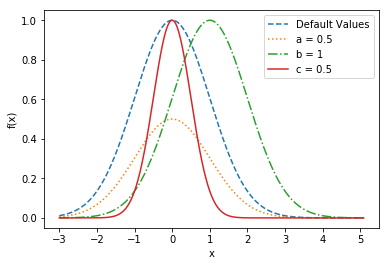

In [17]:
#creating x values for y to be plotted against
x_rng = arange(-3, 5.1, 0.01)

#y values for the default gauss function
g_default = [gauss(i) for i in x_rng ]

#y values the gaussian for a = 0.5
g_a =  [gauss(i, a=0.5) for i in x_rng ]

#y_values the gaussian for b = 1
g_b = [gauss(i, b = 1) for i in x_rng ]

#y_values the gaussian for c = 0.5
g_c =  [gauss(i, c=0.5) for i in x_rng ]

fig_1 = plot(x_rng, g_default, '--', label= 'Default Values')
plot(x_rng, g_a, ':', label = "a = 0.5",)
plot(x_rng, g_b, '-.', label ="b = 1")
plot(x_rng, g_c, label ="c = 0.5")
legend()



ylabel('f(x)')
xlabel('x')



## Collatz

In [18]:
## Define f here
def f(n):
    '''
    Return n/2 if n even and 3n+1 if n odd
    
    Parameters:
    -----------
    n : int
       input integer
    
    Returns:
    --------
      f(n) : int
    '''
    
    # as a safeguard I should test if n is really an integer
    if isinstance(n, int)==False:
        print("Warning in f: n is not integer, will try to turn it into one.")
        n = int(n)
    
    if n % 2 == 0:
        return n//2
    else:
        return 3*n+1

In [19]:
print(f(2), f(3), f(4), f(5))

1 10 2 16
